# Short-time Fourier Transform
on audio files

STFT is a DFT on defined time chunks

## Load audio files

In [1]:
import os
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('..', '..', 'src_audio')
load_content = False

src_audio_data = datasets.load_files (container_path=container_path,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [2]:
src_audio_data.keys ()

dict_keys(['DESCR', 'filenames', 'target_names', 'target'])

## Prepare audio files and perform FFT

### Function definitions pt. 1
<a href='https://docs.scipy.org/doc/scipy/reference/signal.html'>https://docs.scipy.org/doc/scipy/reference/signal.html</a>

<a href='https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform'>https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform</a>

<a href='https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter'>https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter</a>


explanation of signal data:
- *sig_fs* = sampling rate (samples per second)
- *sig_ch* = number of channels
- *sig_N* = number of samples
- *sig_nw* = sample width (bytes)
- *sig_len* = length of signal (seconds)
- *sig* = signal data (array of samples)

In [3]:
# ----- read audio signal
from scipy.io import wavfile

def read_audio_signal (filename):
    print ('>>> reading audio file...', end=' ', flush=True)
    sig_fs, sig = wavfile.read (filename)
    
    #check length of signal
    if (sig_fs*30. != sig.shape[0]):
        print ()
        print ('  [E] length of signal not 30 s, correcting signal...', end= ' ', flush=True)
        if (sig_fs*30. < sig.shape[0]): # signal too long
            too_much = round ((sig.shape[0]/sig_fs - 30.)*sig_fs)
            sig = sig[:(-1*too_much)]
    
    print ('done')
    
    return sig_fs, sig


# ----- signal preparation
PARAM_DEC_FAC = 2 # PARAM: decimation factor

from scipy import signal

def prepare_signal (sig_fs, sig):
    sig_prep = np.copy (sig)
    
    print ('>>> reducing signal to one channel...', end=' ', flush=True)
    sig_ch = len (sig.shape)
    if sig_ch == 2:
        sig_prep = sig_prep.sum (axis=1) / 2
    print ('done')
    
    print ('>>> decimation of signal by (factor {})...'.format (PARAM_DEC_FAC), end=' ', flush=True)
    sig_prep = signal.decimate (sig_prep, q=PARAM_DEC_FAC, ftype='fir').astype (dtype=sig.dtype, copy=False)
    print ('done')
    
    return int (sig_fs/PARAM_DEC_FAC), sig_prep


# ----- discrete Fourier transform
import numpy as np
import scipy
import scipy.fftpack

def dft_signal (sig_fs, sig_slices):
    print ('>>> performing Fourier transformation...', end=' ', flush=True)
    
    len_fft_mags_half = sig_slices.shape[1]//2
    # https://www.safaribooksonline.com/library/view/elegant-scipy/9781491922927/ch04.html#frequences_and_their_ordering
    # input is real valued > fft mags are conjugate symmetrical > take half of the spectrum
    # https://dsp.stackexchange.com/questions/1406/real-discrete-fourier-transform
    # fft magnitudes [X0, ..., XN-1] are mirrored: [X1, ..., XN/2] = [XN-1, ..., XN/2+1]
    # first value represents the 'Direct Current' component (= mean of signal) > not needed
    sig_fft_mags = scipy.fft (sig_slices, axis=1)[:, 1:len_fft_mags_half+1]
    sig_fft_mags = np.abs (sig_fft_mags)
    
    # get the frequency bin centers in cycles per unit of the sample spacing (with zero at the start)
    freq_bins = list (range (0, len (sig_slices[0])))
    freq_bins_f = (np.array (freq_bins) / len (sig_slices[0])) * sig_fs # convert bins to frequency range
    
    #freq_bins_f = scipy.fftpack.fftfreq (sig_slices[0].size) * sig_fs
    
    print ('done')
    
    return sig_fft_mags, freq_bins_f[0:len_fft_mags_half]

#### function - slice signal in several time chunks, windowing signal

length of each time chunk = 1024 S

[2018-08-21] better higher values > dependent on the highest bpm of a song.

let's say: 300 bpm = 300 / 60 = 5 bps => 1 beat per 0.2 s = 0.2 s * 22050 S/s = 4410 S > 4410 S taken

In [5]:
# ----- slice signal in parts where number of samples are to the power of 2
PARAM_N = 4410 #1<<12 # PARAM: number of samples for one dft

import math
import numpy as np

def slice_signal (sig):
    print ('>>> slicing signal...', end=' ', flush=True)
    sig_N = sig.shape[0]
    num_slices = math.floor (sig_N / PARAM_N)
    if (num_slices*PARAM_N < sig_N):  # one more slice usually needed -> checked here
        num_slices += 1
    sig_slices = np.empty ((num_slices, PARAM_N))

    for i in range (num_slices):
        sl = np.copy (sig)[i*PARAM_N:(i+1)*PARAM_N]
        # only last slice of source signal will differ in length
        if (i == (num_slices-1)):
            num_zeros = PARAM_N-sl.size
            sl = np.append (sl, np.full (num_zeros, 0, dtype=sl.dtype))
    
        sig_slices[i] = sl
    print ('done')
    print ('  [i] signal sliced in {} parts, each {} samples.'.format (sig_slices.shape[0], sig_slices.shape[1]))
    
    return sig_slices


# ----- windowing signal (Hanning window is used)
PARAM_WIN = signal.hann (PARAM_N) # PARAM: type of window

import numpy as np
from scipy import signal

def window_signal (sig_slices):
    sig_slices_win = np.copy (sig_slices)
    print ('>>> windowing signal...', end=' ', flush=True)
    for i in range (sig_slices_win.shape[0]):
        sig_slices_win[i] = sig_slices_win[i]*PARAM_WIN
    print ('done')
    
    return sig_slices_win

#### function - zero-pad signal

number of zeros to pad is dependet on frequency resolution of dft

in this case, it depends on the smallest distance between two pitches

$C\#_{0} - C_0 = 17.32391444 Hz - 16.35159783 Hz = 0.9723166047670908 Hz$, value is round to 0.9 Hz

frequency bins distance = 1 / (PARAM_N + PARAM_N_ZEROS) * sampling rate <= 0.9

PARAM_N_ZEROS >= sampling rate / 0.9 - PARAM_N = 22050 / 0.9 - PARAM_N = 24500 - PARAM_N

PARAM_N_ZEROS + PARAM_N >= 24500, next higher value to the power of 2 = 32768

In [6]:
# ----- zero-padding of signal
# number of samples of the time-domain signal dictate the resolution in the frequency-domain
PARAM_N_ZEROS = (1<<15) - PARAM_N # PARAM: number of zeros to add

import numpy as np

def zpad_signal (sig_slices):
    print ('>>> zero-padding signal...', end=' ', flush=True)
    sig_slices_zpad = np.empty ((sig_slices.shape[0], sig_slices.shape[1]+PARAM_N_ZEROS))
    for i in range (sig_slices.shape[0]):
        sig_slices_zpad[i] = np.append (sig_slices[i], np.full (PARAM_N_ZEROS, 0, dtype=sig_slices[i].dtype))
    print ('done')
    print ('  [i] new shape of signal slice', sig_slices_zpad.shape)
    
    return sig_slices_zpad

In [7]:
print ('[i] Parameters:')
print ('    decimation factor:', PARAM_DEC_FAC)
print ('    number of samples per signal time chunk:', PARAM_N)
print ('    number of padded zeros:', PARAM_N_ZEROS)
print ()
print ('[i] for an audio signal of 30s this results in:')
print ('    sampling rate:', int(44100/PARAM_DEC_FAC), 'S/s')
print ('    number of signal slices:', int (math.ceil (30*22050/PARAM_N)))
print ('    number of samples in one zero-padded signal slice:', PARAM_N+PARAM_N_ZEROS, 'S', '(used for DFT)')
print ('    length of one signal slices: {:.3f} s'.format (PARAM_N/22050))

[i] Parameters:
    decimation factor: 2
    number of samples per signal time chunk: 4410
    number of padded zeros: 28358

[i] for an audio signal of 30s this results in:
    sampling rate: 22050 S/s
    number of signal slices: 150
    number of samples in one zero-padded signal slice: 32768 S (used for DFT)
    length of one signal slices: 0.200 s


### Function definitions pt. 2

#### Twelve-tone equal temperament (12TET)
- used to assign the dft magnitudes into bins of pitch ranges

<a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies'>SPN: tables of note frequencies</a>

In [8]:
# ----- pitch frequencies of 12TET
import numpy as np

pitch_A0 = 27.5
pitch_Ax = np.array ([pitch_A0*(2**n) for n in range (-1, 11)])
twtet_pitch_ratios = np.array ([2**(n*1/12) for n in range (-9, 3)])

twtet_pitches = np.empty ((11,12)) # shape is 11 octaves, each 12 pitches
for i in range (11):
    twtet_pitches[i] = pitch_Ax[i] * twtet_pitch_ratios

twtet_pitches = twtet_pitches.flatten ()
# MIDI notation has only 128 numbers
twtet_pitches_last = twtet_pitches[129] # this is important for the frequency bins of the spectrorgam later
twtet_pitches = twtet_pitches[:128]

# we take only 108 pitches (extended piano)
#pitch_C0_midi = 12
#twtet_pitches_last = twtet_pitches[129] # this is important for the frequency bins of the spectrorgam later
#twtet_pitches = twtet_pitches[pitch_C0_midi:128]

# only take 88 pitches (standard piano)
#pitch_A0_midi = 21
#pitch_C8_midi = 108
#twtet_pitches_last = twtet_pitches[pitch_C8_midi+1] # this is important for the frequency bins of the spectrorgam later
#twtet_pitches = twtet_pitches[pitch_A0_midi:pitch_C8_midi+1] # from A0 to C8 (including)

pitch_A4_midi = 69
print ('[i] 12-TET pitches')
print ('    count:', twtet_pitches.size)
print ('    example: A4= {} Hz'.format (twtet_pitches[pitch_A4_midi]))

[i] 12-TET pitches
    count: 128
    example: A4= 440.0 Hz


#### function - create spectrogram
output: 2dim numpy array with values in range [0, 255] (image bit range)

In [9]:
# ----- make spectrogram
PARAM_PITCH_THRESHOLD_P = 0.25 # PARAM: to prevent distortion in spectrogram
PARAM_N_FFT_MAGS = 1<<4 # PARAM: get only some values of the fft magnitudes > to prevent wrong pitches in spectrogram

def create_spectrogram (sig_fft_mags, freq_bins_f):
    print ('>>> creating spectrogram...', end=' ', flush=True)
    spectro = np.zeros (twtet_pitches.shape[0])
    
    for i in range (sig_fft_mags.shape[0]):
        # get only some values of the fft magnitudes
        cpy = np.copy (sig_fft_mags[i])
        freq_list = []
        num_fft_mags = 0
        while (num_fft_mags < PARAM_N_FFT_MAGS):
            bin_n = np.argmax (cpy)
            freq_list.append (freq_bins_f[bin_n])
            cpy = np.delete (cpy, bin_n)
            num_fft_mags += 1
            
        hist, edges = np.histogram (freq_list, bins=np.concatenate ((twtet_pitches, twtet_pitches_last), axis=None),
                                    range=(twtet_pitches.min(), twtet_pitches_last))
        
        # convert to bit scale [0, 255]
        max_val = hist.max ()
        if (max_val == 0):
            spectro = np.vstack ((spectro, hist))
            continue
        
        # [2018-08-29 - new PARAM to prevent distortion in spectrogram]
        hist = (hist / max_val > PARAM_PITCH_THRESHOLD_P) * hist
        
        hist = int (255 / max_val) * hist
        spectro = np.vstack ((spectro, hist))
    print ('done')
    
    return spectro[1:] # due to init of an empty array + vstack, first row can be deleted

#### function - resize spectrogram

standard setup: make height same as width, dependent on width

In [10]:
# ----- resize function for spectrogram
import numpy as np
import math

def resize_spectrogram (spectro):
    print ('>>> resizing spectrogram to [150, 150]...', end=' ', flush=True)
    m = spectro.shape[0]
    n = spectro.shape[1]
    
    # just in case - condition: there are always more signal slices than pitch bins
    if (m <= n):
        print ('[E] m <= n')
        return spectro
    
    # how often fits the width in the height?
    #mul_per_col = math.floor (m/n)
    # how many additional cols to add?
    #cols_to_add = m - (mul_per_col * n)
    
    mul_per_col = 2
    
    #new_spectro = np.empty ((1, m))
    spectro_resized = np.empty ((1, mul_per_col*n))
    for i in range (m):
        new_line = np.empty (1)
        for j in range (n):
            mn = np.full (mul_per_col, spectro[i][j])
            new_line = np.concatenate ((new_line, mn), axis=None)
        #new_line = np.concatenate ((new_line, np.zeros (cols_to_add)), axis=None)
        spectro_resized = np.vstack ((spectro_resized, new_line[1:]))
    
    print ('done')
    
    return spectro_resized[1:]

setup #1: resize spectrogram to same width and height

prerequisites:
- spectrogram rows = # of time chunks (signal slices) = 150 for PARAM_N=4410, sampling rate=22050
- spectrogram columns = 12-TET in MIDI range = 128

this leads to: append 22 zeros per column

output: resized spectrogram [150, 150]

In [11]:
# ----- resize function for spectrogram
import numpy as np
import math

def resize_spectrogram_150 (spectro):
    print ('>>> resizing spectrogram to [150, 150]...', end=' ', flush=True)
    m = spectro.shape[0] #150
    n = spectro.shape[1] #128
    
    # just in case - prerequisite: there are always more signal slices than pitch bins
    if (m <= n):
        print ('  [E] m <= n')
        return spectro
    
    
    # how many additional cols to add?
    cols_to_add = m - n
    
    spectro_resized = np.empty ((1, m))
    for i in range (m):
        new_line = np.append (spectro[i], np.zeros (cols_to_add))
        spectro_resized = np.vstack ((spectro_resized, new_line))
    
    print ('done')
    
    return spectro_resized[1:]

## Let's do it

In [12]:
import os
from PIL import Image

save_path = os.path.join ('..', '..', 'src_spectro')
for i, filename in enumerate (src_audio_data['filenames']):
    print ('\r[i] processing {} of {} audio files'.format (i+1, src_audio_data['filenames'].shape[0]), end='\n')

    sig_fs, sig = read_audio_signal (filename)

    sig_prep_fs, sig_prep = prepare_signal (sig_fs, sig)

    sig_prep_slices = slice_signal (sig_prep)
    
    # special windowing currently used (that means, rectangular window is used)
    sig_prep_slices = window_signal (sig_prep_slices)

    sig_prep_slices_zpad = zpad_signal (sig_prep_slices)

    sig_fft_mags, freq_bins_f = dft_signal (sig_prep_fs, sig_prep_slices_zpad)

    spectro = create_spectrogram (sig_fft_mags, freq_bins_f)
    
    # resizing not used, since it distorts the picture imo
    #spectro = resize_spectrogram (spectro)
    
    # resizing to same width and height for cnn
    # [2018-08-28] this will be done in data preprocessing of cnn, since it belongs to it
    #spectro = resize_spectrogram_150 (spectro)

    # ----- edit images: convert to 8 Bit and rotate by 90 degrees
    base_name, _ = os.path.splitext(os.path.basename (filename))
    target_name = src_audio_data['target_names'][src_audio_data['target'][i]]
    save_as = os.path.join (save_path, target_name, base_name + '.png')
    print ('>>> rotating and saving image as {} ...'.format (save_as), end=' ', flush=True)
    img = Image.fromarray (spectro)
    img = img.rotate (90, expand=1)
    img = img.convert ('RGB')
    img.save (save_as)
    print ('done')

[i] processing 1 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... 

/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/11-0/TRHVOIL128F92E92E6.png ... done
[i] processing 2 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/8-0/TRYULKJ128F933B1D9.png ... done
[i] processing 3 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new sh

>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/1-1/TRCWPJT128F92F87F4.png ... done
[i] processing 18 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/0-0/TRMQFWW128F1465DC5.png ... done
[i] processing 19 of 290 audio files

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/9-1/TRERTES128F426EA61.png ... done
[i] processing 34 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectr

>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/0-1/TRMZWTU128F145E524.png ... done
[i] processing 49 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/6-1/TRSZMTS128F4264B4A.png ... done
[i] processing 50 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>

>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/0-1/TRNPIBB128F92ED9D9.png ... done
[i] processing 65 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/2-0/TRVPKML128F427AA59.png ... done
[i] processing 66 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> s

>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/3-0/TRRDJNJ12903CBE857.png ... done
[i] processing 80 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/8-1/TRHLNZP128F1489125.png ... done
[i] processing 81 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal

>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/6-0/TRIAOVI128F425A16D.png ... done
[i] processing 96 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/1-1/TRTMPFS128F14698A0.png ... done
[i] processing 97 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>

>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/5-1/TRLTJTT128F9342827.png ... done
[i] processing 112 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/4-1/TRCWIZD128EF35EE04.png ... done
[i] processing 113 of 290 audio files
>>> readi

>>> rotating and saving image as ../../src_spectro/2-1/TRCTQJS128F93012CF.png ... done
[i] processing 127 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/7-1/TRWDRKJ128F4277E39.png ... done
[i] processing 128 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creatin

>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/4-0/TRUHBDS128F9311380.png ... done
[i] processing 143 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/9-1/TRCANAT128E078B0EC.png ... done
[i] processing 144 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 part

>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/5-1/TRDTAUE12903CEFF8C.png ... done
[i] processing 159 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/1-0/TRUBEOU128F422E200.png .

>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/1-0/TRNAFXW128F427CA09.png ... done
[i] processing 174 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/10-0/TRENOSF128F14552A5.png ... done
[i] processing 175 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of sig

>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/5-0/TRHDYVW128F421A79D.png ... done
[i] processing 190 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/7-0/TRROBXQ128F428D2BD.png ... done
[i] processing 191 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 part

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/7-1/TRIKNPG128E0792FF0.png ... done
[i] processing 206 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/3-1/TRPRGXQ128F92F64D4.png ... done
[i] processing 2

>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/8-1/TRPMZQC128F14693DA.png ... done
[i] processing 221 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/5-1/TRCWNLD128F93011AD.png ... done
[i] processing 222 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier t

>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/1-1/TRFGVOO128F92F9E2D.png ... done
[i] processing 237 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/4-0/TRGYFTS128F9306691.png ... done
[i] processing 238 of 290 audio files
>>> readi

>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/11-0/TRYGIDP12903CE1349.png ... done
[i] processing 252 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/0-0/TRRTCMY128F9326B32.png ... done
[i] processing 253 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done

>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/4-1/TRQAHKH128F4266395.png ... done
[i] processing 268 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/4-0/TRLEZCK12903CE563B.png ... done
[i] processing 269 of 290 audio files
>>> reading audio file... 
  [E] length of signal not 30 s, correcting signal... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>>

>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/2-1/TRRBJPD128F9331C9E.png ... done
[i] processing 284 of 290 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... done
>>> creating spectrogram... done
>>> rotating and saving image as ../../src_spectro/9-1/TRZURID128F933F6C3.png ... done
[i] processing 285 of 290 audio files
>>> readi

## Example

In [13]:
import os

#filename = os.path.join ('test', '94812__digifishmusic__c4-major-scale-piano.wav')
#filename = os.path.join ('test', '134012__davidkyoku__c-major-scale.wav')
#filename = os.path.join ('test', 'c-major-scale-on-treble-clef.wav')
filename = os.path.join ('..', '..', 'src_audio', '5-0', 'TRTPAWR12903D017C7.wav')

sig_fs, sig = read_audio_signal (filename)

sig_prep_fs, sig_prep = prepare_signal (sig_fs, sig)

sig_prep_slices = slice_signal (sig_prep)

sig_prep_slices_win = window_signal (sig_prep_slices)

sig_prep_slices_zpad = zpad_signal (sig_prep_slices)

sig_fft_mags, freq_bins_f = dft_signal (sig_prep_fs, sig_prep_slices_zpad)

spectro = create_spectrogram (sig_fft_mags, freq_bins_f)

>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal by (factor 2)... done
>>> slicing signal... done
  [i] signal sliced in 150 parts, each 4410 samples.
>>> windowing signal... done
>>> zero-padding signal... done
  [i] new shape of signal slice (150, 32768)
>>> performing Fourier transformation... 

/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


done
>>> creating spectrogram... done


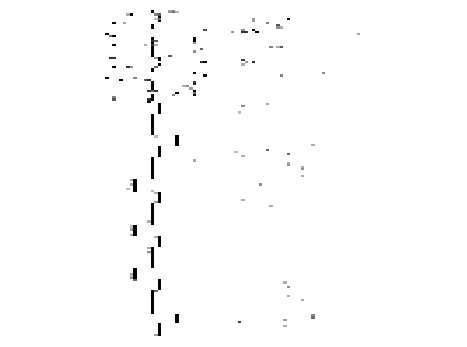

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots (1, 1, sharex=True)
extent = [0, twtet_pitches.size, 0, 1]
axs.imshow (spectro, aspect='auto', cmap="binary", extent=extent)
axs.axis ('off')
axs.axes.get_xaxis().set_visible (False)
axs.axes.get_yaxis().set_visible (False)

fig.set_size_inches (8, 6)
plt.show ()

In [15]:
# ----- edit images: convert to 8 Bit and rotate by 90 degrees
from PIL import Image

base_name, _ = os.path.splitext(os.path.basename (filename))
save_as = os.path.join ('test', base_name + '.png')
print ('>>> rotating and saving image as {} ...'.format (save_as), end=' ', flush=True)
img = Image.fromarray (spectro)
img = img.rotate (90, expand=1)
#img = img.resize ((int(spectro.shape[0]/2), spectro.shape[1]))
#img = img.resize ((spectro.shape[0]*1, spectro.shape[1]*1))
img = img.convert ('RGB')
img.save (save_as)
print ('done')

>>> rotating and saving image as test/TRTPAWR12903D017C7.png ... done


[i] Example
signal information:
  channels: 2
  sampling rate: 44100 Hz (S/s)
  number of samples: 1323000 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.00 s


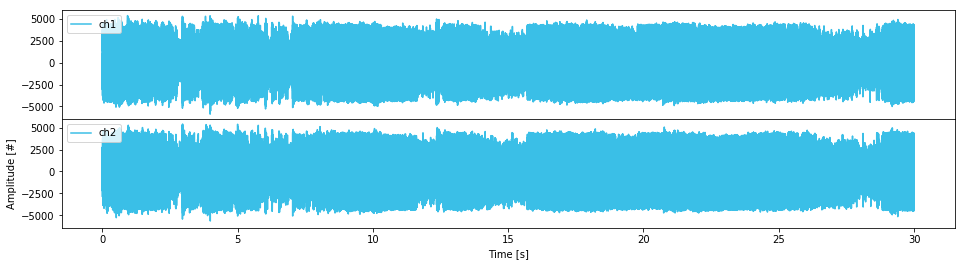

In [16]:
# FYI: EXAMPLE
import matplotlib.pyplot as plt
%matplotlib inline

print ('[i] Example')

sig_ch = len (sig.shape) # number of channels
sig_N = sig.shape[0] # number of samples
sig_nw = sig.dtype.itemsize # sample width
sig_len = sig_N/sig_fs # length of signal

print ('signal information:')
print ('  channels:', sig_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_fs))
print ('  number of samples: {} S'.format (sig_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_nw, sig_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_len))


# plot sample of wav file
t = np.linspace (0, len (sig)/sig_fs, sig_N)

fig, axs = plt.subplots (2, 1, sharex=True, sharey=True)

axs[0].step (t, sig[:,0], c="#3ABFE7", label='ch1')
axs[0].legend (loc='upper left')

axs[1].step (t, sig[:,1], c="#3ABFE7", label='ch2')
axs[1].legend (loc='upper left')

_ = plt.ylim()
fig.set_size_inches ((16., 4.), forward=True)
fig.suptitle ('')
fig.subplots_adjust (hspace=0)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show()

[i] Example
signal information:
  channels: 1
  sampling rate: 22050 Hz (S/s)
  number of samples: 661500 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.00 s


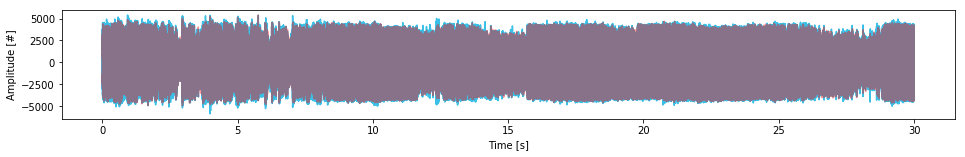

In [17]:
# FYI: EXAMPLE
print ('[i] Example')

sig_prep_ch = len (sig_prep.shape) # number of channels
sig_prep_N = sig_prep.shape[0] # number of samples
sig_prep_nw = sig_prep.dtype.itemsize # sample width
sig_prep_len = sig_prep_N/sig_prep_fs # length of signal

print ('signal information:')
print ('  channels:', sig_prep_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_prep_fs))
print ('  number of samples: {} S'.format (sig_prep_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_prep_nw, sig_prep_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_prep_len))

plt.figure(figsize=(16.,2.))
plt.step (t, sig[:, 0], c="#3ABFE7", label='src ch1')

t_prep = np.linspace (0, len (sig_prep)/sig_prep_fs, sig_prep_N)
plt.step (t_prep, sig_prep, c="#FF0000", alpha=0.4, label='mono')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show ()

## Short-Time Fourier Transformation (STFT)
---

## simple example for windowing

### cosine wave and its dft

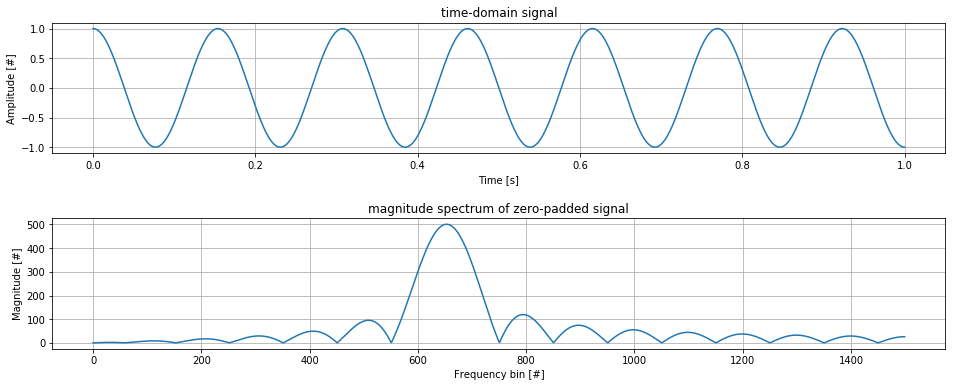

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 1000 # frames per second
T = 1/fs
N = 1000 # samples
n = list (range (0,N))
t = np.linspace (0, len (n)*T, N)
x = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz

# -----

import scipy
import scipy.fftpack

x_zpad = np.append (x, np.full (99000, 0))
X_ZPAD_mags = abs (scipy.fft (x_zpad))
bins = list (range (0, len (x_zpad)))


# -----

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure (figsize=(16.,6.))
plt.subplot (211)
plt.plot (t, x)
plt.title ('time-domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')
plt.grid (True)
plt.subplot (212)
plt.plot (bins[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency bin [#]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.5)
plt.show ()

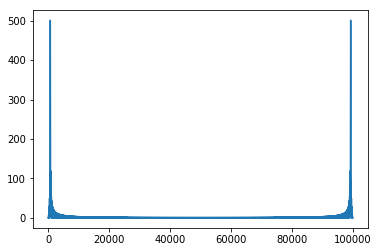

In [24]:
plt.plot (bins, X_ZPAD_mags)

In [98]:
len_dft_half = int (X_ZPAD_mags.shape[0]/2)
# fft magnitudes [X0, ..., XN-1] are mirrored:
# [X1, ..., XN/2-1] = [XN-1, ..., XN/2+1] > [1, 49999] = [99999, 50000]
diff = X_ZPAD_mags[1:len_dft_half] - X_ZPAD_mags[:len_dft_half:-1]
print (diff.sum ())

-7.108032261359451e-11


In [68]:
x = np.array (list(range(0,5)))
x = np.append (x, x[::-1])
diff = x[:5] - x[:-6:-1]
print (diff)

[0 0 0 0 0]


above DFT magnitude spectrum plot shows the first 1500 bins

the frequency with highest magnitude is calculated by:

bin_num / len (x_zpad) \* fs = 650 / 100.000 \* 1.000 = 6.5 Hz

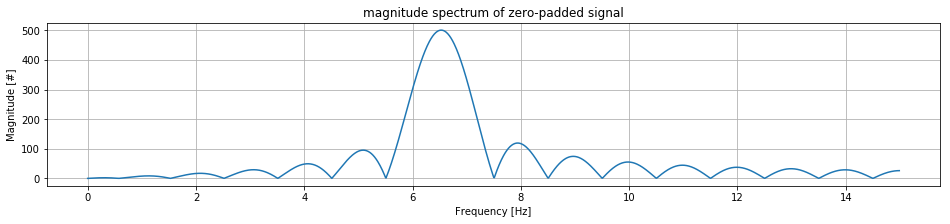

frequency with highest magnitude = 6.53 Hz


In [22]:
# now bins will be converted to frequency range
import matplotlib.pyplot as plt
%matplotlib inline

fax = np.array (bins) * fs / len (x_zpad)

plt.figure (figsize=(16.,3.))
plt.plot (fax[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.show ()

print ('frequency with highest magnitude = {} Hz'.format (fax[np.argmax(X_ZPAD_mags)]))

### rectangular window

first: look at signals in time-domain

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (win[0:Ndisp])
plt.title ('rectangular window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

Interpretation of rectangular window: the sinusoidal signal (graph 2) is multiplied by the rectangular window (graph 3) in order to get the zero-padded signal (graph 1)

second: now let's see how the requency-domain looks like

In [ ]:
fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (win))[-1000:])
plt.title ('double-sided magnitude of rectangular window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

As shown, the sinusoidal signal is in general just a line in frequency-domain. But due to the applied rectangular window in time-domain, the dft ends up like for the zero-padded signal.

Consequence: **Convolution** = multiplication in time-domain results in convolution in frequency-domain

### hanning window
same as above, nut now with hanning window

In [ ]:
### time-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

# THIS IS THE IMPORTANT PART - multiply window with time-domain signal
han_win = signal.hann (N)
x_zpad_win = np.append (x*han_win, np.full (99000, 0))

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad_win[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)


plt.subplot (313)
plt.plot (np.append (han_win, np.zeros (99000))[0:Ndisp])
plt.title ('hanning window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

sinusiodal signal is multiplied with hanning window to get the zero-padded signal (graph 1)

In [ ]:
# frequency-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline


X_ZPAD_win_mags = abs (scipy.fft (x_zpad_win))
#bins = list (range (0, len (x_zpad)))


fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad_win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad_win))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplot (313)

plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (np.append (han_win, np.zeros (99000))))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (np.append (han_win, np.zeros (99000)))[-1000:]))
plt.title ('double-sided magnitude of hanning window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.tight_layout ()
plt.show ()

## influence of zero-padding
the more zeros padded, the higher the resolution in frequency-domain

since the dft-bins are dictated by the number of samples in time-domain signal

the lower res spectrums are a sampled version of the higher res ones

## deprecated stuff
just for information - messy style

In [ ]:
# read wav file
import wave
import numpy as np

wav_params = None
wav_frames = None
with wave.open (audio_out) as wav_file:
    wav_params = wav_file.getparams ()
    wav_frames = wav_file.readframes (-1)

print ('signal information:')
print ('  channels:', wav_params[0])
print ('  sampling rate: {} Hz (S/s)'.format (wav_params[2]))
print ('  number of samples: {} S'.format (wav_params[3]))
print ('  sample width: {} Bytes = {} Bits'.format (wav_params[1], wav_params[1]*8))
print ('  length of signal: {:.2f} s'.format (wav_params[3]/wav_params[2]))
print ('example of signal samples:')
print ('  ', wav_frames[30000:30010])
wav_frames = np.frombuffer (wav_frames, dtype=np.int16)
print ('  ', wav_frames[30000:30010])
print (wav_frames.dtype)

In [ ]:
# Fourier transformation requires input signal with number of samples to be a power of 2
# if not, zero-pad the signal
# from https://www.geeksforgeeks.org/smallest-power-of-2-greater-than-or-equal-to-n/
if not (sig_prep_N & (sig_prep_N-1) == 0):
    print ('[i] signal length not a power of 2')
    print ('>>> zero-padding the signal...', end=' ', flush=True)
    # get number of zeros to add
    k = sig_prep_N
    while (k&(k-1) > 0):
        k = k&(k-1)
    k = k<<1
    num_zeros = k - sig_prep_N
    # add zeros to end of signal
    sig_prep = np.append (sig_prep, np.full (num_zeros, 0, dtype=sig_prep.dtype))
    sig_prep_N = sig_prep.shape[0]
    sig_prep_len = sig_prep_N/sig_prep_fs
    print ('done')

print (sig_prep_N)
print (sig_prep_len)

---

# Obsolete

## Decode MP3 to WAV
why obsolete: Initial idea was to store mp3 files since they are smaller in size, and then convert them to wav.

In [ ]:
import subprocess
import os


curr_dir = os.path.abspath ('./')
ffmpeg = os.path.join (curr_dir, 'src', 'ffmpeg-20180719-9cb3d8f-win64-static', 'bin', 'ffmpeg.exe')
ffmpeg_opt_main = '-n -i'
ffmpeg_opt_wav = '-ar 44100 -ac 2'
audio_name = "Rick Astley - Never Gonna Give You up"
#"2017-06-16 - CamelPhat, Elderbrook - Cola [Original Mix]"
#"2015-05-29 - Tough Love - So Freakin' Tight [Original Mix]"
audio_in = os.path.join ('src', audio_name + '.mp3')
audio_out = os.path.join ('src', audio_name + '.wav')

cmd = ffmpeg + ' ' + ffmpeg_opt_main + ' ' + \
    "\"" + audio_in + "\"" + ' ' + ffmpeg_opt_wav + ' ' + \
    "\"" + audio_out + "\""

subprocess.call (cmd, shell=True)

In [ ]:
# [2018-08-16] turned out, that an image of 88x88 pixel is too small for the CNN
# > increase size by adding also half pitches to the frequency range
twtet_pitch_ratios_half = np.array ([2**(n*1/24) for n in range (-18, 6)])

twtet_pitches_half = np.empty ((11, 24)) # shape is 11 octaves, each 24 half pitches
for i in range (11):
    twtet_pitches_half[i] = pitch_Ax[i] * twtet_pitch_ratios_half
twtet_pitches_half = twtet_pitches_half.flatten ()

twtet_pitches_half = twtet_pitches_half[pitch_A0_midi*2:(pitch_C8_midi+1)*2]